In [ ]:
%load_ext autoreload

In [ ]:
%autoreload 2
from subgrid_parameterization.preprocess import SAM_helpers as sam
from subgrid_parameterization.preprocess.C14 import get_C14
from subgrid_parameterization.preprocess.mixing_length import get_mixing_length

import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from sklearn.metrics import r2_score

In [ ]:
path0 = "/glade/work/stepheba/les_and_clubb_benchmark_runs/stepheba_sam_runs/derecho/"

path = "sam-bomex/"
file = "BOMEX_64x64x75_100m_40m_1s"
# file = 'BOMEX_3d'

# path = "sam-rf01/"
# file = "DYCOMS_RF01_96x96x320"
# file = '*_3d'

# # RF01 won't work until stretched grid is implemented
# path = 'sam-rf02/'
# file = 'DYCOMS_RF02_128x128x96_dr_nosed'
# file = '*_3d'

In [ ]:
ds = xr.open_dataset(path0 + path + file + ".nc")

In [ ]:
ds

<xarray.Dataset> Size: 47MB
Dimensions:      (x: 1, y: 1, z: 75, time: 360)
Coordinates:
  * x            (x) float32 4B -56.5
  * y            (y) float32 4B 15.0
  * z            (z) float32 300B 20.0 60.0 100.0 ... 2.9e+03 2.94e+03 2.98e+03
  * time         (time) datetime64[ns] 3kB 1969-06-22T00:01:00 ... 1969-06-22...
Data variables: (12/446)
    p            (z) float32 300B ...
    PREC         (time) float32 1kB ...
    CWP          (time) float32 1kB ...
    IWP          (time) float32 1kB ...
    RWP          (time) float32 1kB ...
    SWP          (time) float32 1kB ...
    ...           ...
    THLPRRP_IP   (time, z, y, x) float32 108kB ...
    RTPNRP_IP    (time, z, y, x) float32 108kB ...
    THLPNRP_IP   (time, z, y, x) float32 108kB ...
    RRPNRP_IP    (time, z, y, x) float32 108kB ...
    RRP3_IP      (time, z, y, x) float32 108kB ...
    NRP3_IP      (time, z, y, x) float32 108kB ...
Attributes:
    SAM version:  
    caseid:       64x64x75_100m_40m_1s
    Conventions:  COARDS

In [ ]:
# nzm, nzt, ngrdcol, zm, zt, dzm, dzt, invrs_dzm, invrs_dzt
nzm, nzt, ngrdcol, zm, zt, dzm, dzt, invrs_dzm, invrs_dzt = sam.get_grid(ds)

In [ ]:
e = sam.get_TKE(ds)

# U2 = sam.stagger_var("U2", ds, zt)
# V2 = sam.stagger_var("V2", ds, zt)
# W2 = sam.stagger_var("W2", ds, zt)
# assert ( e == (0.5 * ( U2 + V2 + W2 ))).all()

In [ ]:
disp = sam.get_disp(ds)

# U2DFSN = sam.stagger_var("U2DFSN", ds, zt)
# V2DFSN = sam.stagger_var("V2DFSN", ds, zt)
# assert ( disp == (0.5 * ( U2DFSN + V2DFSN ))).all()

In [ ]:
C14 = get_C14(ds)
L, Lup, Ldown = get_mixing_length(ds)

# assert (C14 == (-3.0 / 2.0 * L / e**1.5 * disp) ).all()

No programtic way to asses spinup (yet), can be assessed visually:

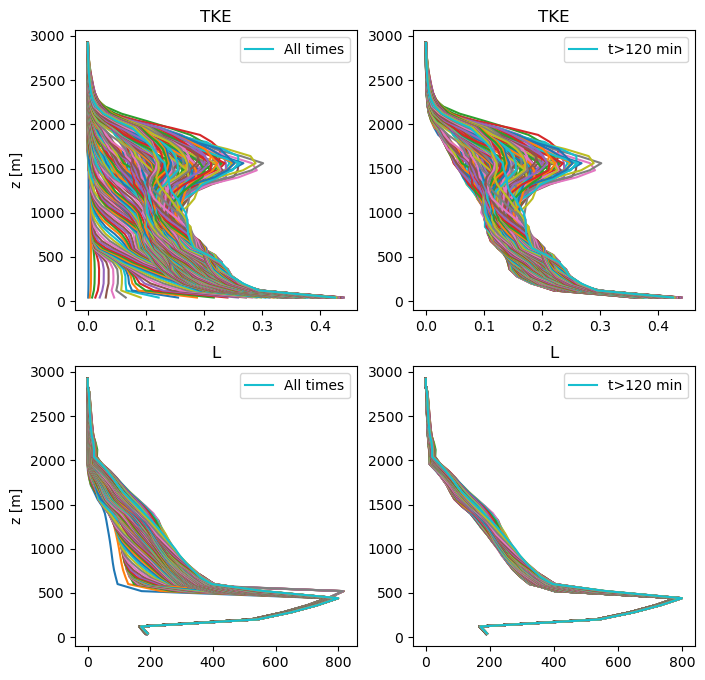

In [ ]:
istart = 120
itime = range(istart, ngrdcol)
kstart = 0
kend = nzm  # -21 #int(0.75*nzm)
try:
    del (fig, axs)
    print("deleted old figure")
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
except:
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].plot(e[:-1, kstart:kend].T, zt[:-1, kstart:kend].T)
axs[0, 0].plot(e[-1, kstart:kend].T, zt[-1, kstart:kend].T, label="All times")
axs[0, 0].legend()
axs[0, 0].set_ylabel("z [m]")
axs[0, 0].set_title("TKE")
axs[0, 1].plot(e[itime[:-1], kstart:kend].T, zt[itime[:-1], kstart:kend].T)
axs[0, 1].plot(
    e[itime[-1], kstart:kend].T,
    zt[itime[-1], kstart:kend].T,
    label="t>" + str(istart) + " min",
)
axs[0, 1].legend()
axs[0, 1].set_title("TKE")
axs[1, 0].plot(L[:-1, kstart:kend].T, zt[:-1, kstart:kend].T)
axs[1, 0].plot(L[-1, kstart:kend].T, zt[-1, kstart:kend].T, label="All times")
axs[1, 0].legend()
axs[1, 0].set_ylabel("z [m]")
axs[1, 0].set_title("L")
axs[1, 1].plot(L[itime[:-1], kstart:kend].T, zt[itime[:-1], kstart:kend].T)
axs[1, 1].plot(
    L[itime[-1], kstart:kend].T,
    zt[itime[-1], kstart:kend].T,
    label="t>" + str(istart) + " min",
)
axs[1, 1].legend()
axs[1, 1].set_title("L");

In [ ]:
print(np.sum(C14 < 0))
print(np.sum(C14 == 0))
print(np.sum(C14 > 0))
print(np.sum(C14 > 2))

219
3486
9615
367


In [ ]:
print(np.sum(disp < 0))
print(np.sum(disp == 0))
print(np.sum(disp > 0))

9615
3486
219


In [ ]:
print(np.sum(e < 0))
print(np.sum(e == 0))
print(np.sum(e >= 0))

0
0
13320


Negative and zero C14 are entirely due to dissipation, while TKE is always positive as it should be.

deleted old figure


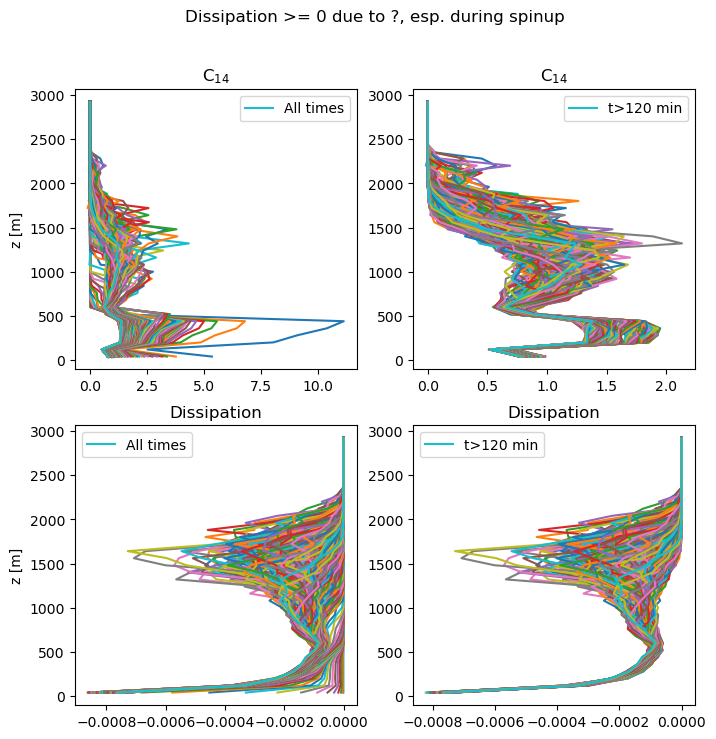

In [ ]:
try:
    del (fig, axs)
    print("deleted old figure")
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))
except:
    fig, axs = plt.subplots(2, 2, figsize=(8, 8))

axs[0, 0].plot(C14[:-1, kstart:kend].T, zt[:-1, kstart:kend].T)
axs[0, 0].plot(C14[-1, kstart:kend].T, zt[-1, kstart:kend].T, label="All times")
axs[0, 0].legend()
axs[0, 0].set_ylabel("z [m]")
axs[0, 0].set_title(r"C$_{14}$")
axs[0, 1].plot(C14[itime[:-1], kstart:kend].T, zt[itime[:-1], kstart:kend].T)
axs[0, 1].plot(
    C14[itime[-1], kstart:kend].T,
    zt[itime[-1], kstart:kend].T,
    label="t>" + str(istart) + " min",
)
axs[0, 1].legend()
axs[0, 1].set_title(r"C$_{14}$")
axs[1, 0].plot(disp[:-1, kstart:kend].T, zt[:-1, kstart:kend].T)
axs[1, 0].plot(disp[-1, kstart:kend].T, zt[-1, kstart:kend].T, label="All times")
#     U2DFSN[itime, kstart:kend].T, zt[itime, kstart:kend].T, "-"
# )  # ,label='U2DFSN')
# plt.plot(
#     V2DFSN[itime, kstart:kend].T, zt[itime, kstart:kend].T, "--"
# )  # label='V2DFSN')
axs[1, 0].legend()
axs[1, 0].set_ylabel("z [m]")
axs[1, 0].set_title("Dissipation")
axs[1, 1].plot(disp[itime[:-1], kstart:kend].T, zt[itime[:-1], kstart:kend].T)
axs[1, 1].plot(
    disp[itime[-1], kstart:kend].T,
    zt[itime[-1], kstart:kend].T,
    label="t>" + str(istart) + " min",
)
axs[1, 1].legend()
axs[1, 1].set_title("Dissipation")
fig.suptitle("Dissipation >= 0 due to ?, esp. during spinup");

Issue of dissipation = 0 = C14 remains at model top, regardless of spinup exclusion. Need clipping + no spinup.

In [ ]:
C14_nonNeg = C14[C14 >= 0]
C14_pos = C14[C14 > 0]

The maximum of C14 set a mimimum for TKE, to avoiding division by near zero. The minimum of C14, sets a minimum for dissipation to elimiate the unexplained but negative dissipation in the LES output (associated with the top boudnary and worse at early times pointing to the sponge layer as the cause, but this is uncomfirmed).

In [ ]:
C14min = 0.2
C14max = 2
minMask = disp < -2 / 3 * C14min / L * e**1.5
maxMask = e > (-1.5 * disp * L / C14max) ** (2 / 3)
C14_clip = C14[minMask & maxMask]

/glade/derecho/scratch/adac/tmp/ipykernel_14543/1087768823.py:4: RuntimeWarning: invalid value encountered in power
  maxMask = e > (-1.5 * disp * L / C14max) ** (2 / 3)


Text(0.5, 0, 'C$_{14}$')

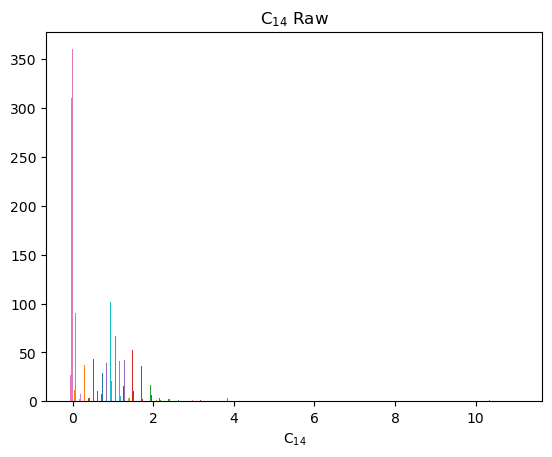

In [ ]:
plt.hist(C14, bins=100)
plt.title(r"C$_{14}$ Raw")
plt.xlabel(r"C$_{14}$")
# plt.ylabel("Count")

Text(0, 0.5, 'Count')

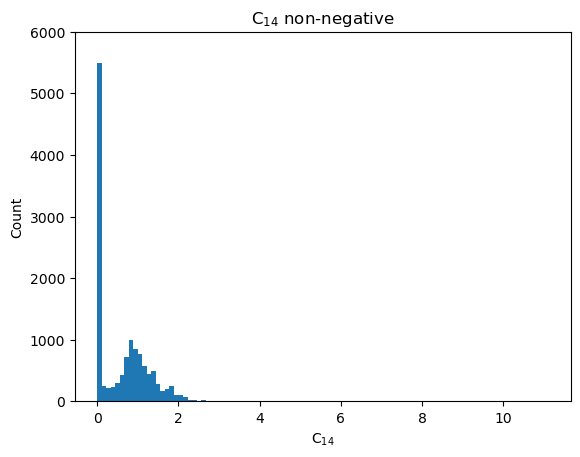

In [ ]:
plt.hist(C14_nonNeg, bins=100)
plt.ylim((0, 6000))
plt.title(r"C$_{14}$ non-negative")
plt.xlabel(r"C$_{14}$")
plt.ylabel("Count")

Text(0.5, 0.98, 'C$_{14}$ positive')

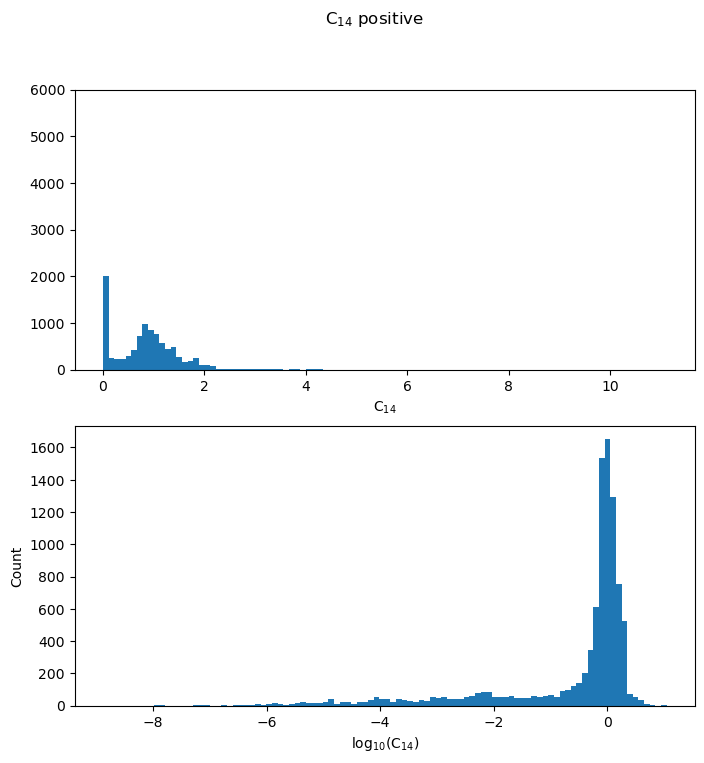

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(8, 8))
axs[0].hist(C14_pos, bins=100)
axs[0].set_ylim((0, 6000))
axs[0].set_xlabel(r"C$_{14}$")
axs[1].hist(np.log10(C14_pos), bins=100)
axs[1].set_xlabel(r"log$_{10}$(C$_{14}$)")
plt.ylabel("Count")
fig.suptitle(r"C$_{14}$ positive")

Text(0, 0.5, 'Count')

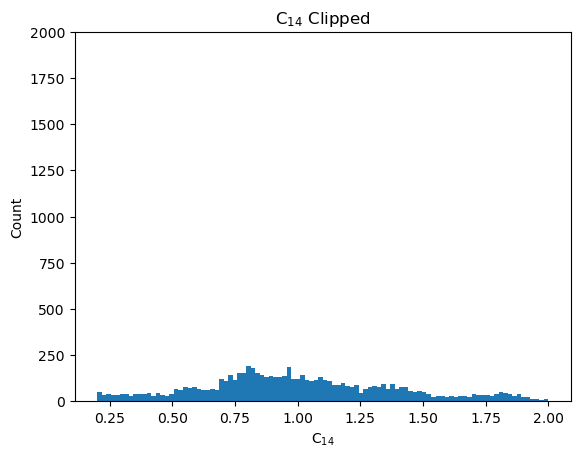

In [ ]:
plt.hist(C14_clip, bins=100)
plt.ylim((0, 2000))
plt.title(r"C$_{14}$ Clipped")
plt.xlabel(r"C$_{14}$")
plt.ylabel("Count")

Not setting the lower bound to C$_{14}$>0 by dissipation < 0, but by a dynamic tolerance on dissipation based on the minimum C$_{14} \neq$ 0 but $\approx$0.2 minimum in CLUBB documentation tuning parameters table. 

In [ ]:
print(np.mean(C14))
print(np.mean(C14_nonNeg))
print(np.mean(C14_pos))
print(np.mean(C14_clip))

0.612029828700826
0.6222868171826276
0.8479021936463447
1.0077896878260582
